In [3]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('sentiwordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


True

In [4]:
import numpy as np
import pandas as pd
import gc
import sys
import scipy
import seaborn as sns
from nltk import word_tokenize, pos_tag
from nltk.tokenize import TreebankWordTokenizer, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.metrics import roc_auc_score, f1_score

In [5]:
data = pd.read_csv('train.csv')

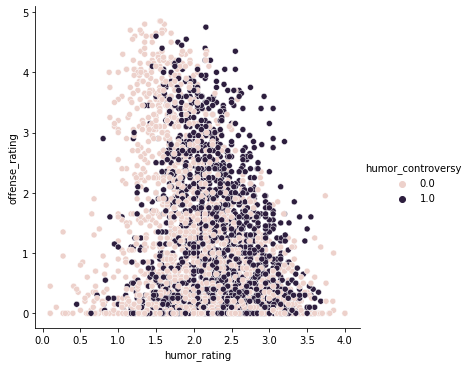

In [9]:
sns.relplot(x=data['humor_rating'], y=data['offense_rating'], hue=data['humor_controversy']);

In [ ]:
data.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


In [ ]:
text = data['text']
text.shape

(8000,)

## Feature engineering: 
Positive and negative scores of entries using SentiWordNet

In [ ]:
# Tokenize sentences
tokenized_text = [word_tokenize(i) for i in text]

In [ ]:
# POS tag and lemmatize words, then count pos/neg words in each entry
# See https://nlpforhackers.io/sentiment-analysis-intro/ for details

lemmatizer = WordNetLemmatizer()

def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

def swn_polarity(text):
    """
    Return a pos and neg score
    """
 
    pos_score = np.zeros(len(text))
    neg_score = np.zeros(len(text))
    tokens_count = 0

    for i in range(0,len(text)):
        tagged_entry = pos_tag(text[i])
 
        for word, tag in tagged_entry:
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
 
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
 
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
 
            # Take the first sense, the most common
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
 
            pos_score[i] += swn_synset.pos_score() 
            neg_score[i] += swn_synset.neg_score()

    return pos_score, neg_score


In [ ]:
pos_score, neg_score = swn_polarity(tokenized_text)
print(pos_score, neg_score)

[0.875 0.75  0.    ... 0.125 0.25  1.125] [0.25  0.    0.375 ... 0.    0.25  0.125]


In [ ]:
data['pos_score'] = pos_score
data['neg_score'] = neg_score

In [ ]:
data.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating,pos_score,neg_score
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2,0.875,0.250
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1,0.750,0.000
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4,0.000,0.375
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0,1.750,0.500
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1,1.125,1.500


In [ ]:
data.shape

(8000, 8)

Create test-train split

In [ ]:
X = data[['text', 'pos_score', 'neg_score']]
y = data['is_humor']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## Text Preprocessing
Taken from Satya's notebook

In [ ]:
_treebank_word_tokenizer = TreebankWordTokenizer()

def word_tokenize(text, language='english'):
    """
    Return a tokenized copy of *text*,
    using NLTK's recommended word tokenizer
    (currently an improved :class:`.TreebankWordTokenizer`
    along with :class:`.PunktSentenceTokenizer`
    for the specified language).

    :param text: text to split into words
    :type text: str
    :param language: the model name in the Punkt corpus
    :type language: str
    """
    sentences = sent_tokenize(text, language)
    return [
        token for sent in sentences for token in _treebank_word_tokenizer.tokenize(sent)
    ] 

In [ ]:
tokenizer = TreebankWordTokenizer()
vectorizer = CountVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize)
count_vec_train = vectorizer.fit_transform(X_train['text']).astype('uint8')
count_vec_test = vectorizer.transform(X_test['text']).astype('uint8')

In [ ]:
type(count_vec_train)

scipy.sparse.csr.csr_matrix

Stacking features

In [ ]:
def stack_sentiment(count_vec, pos_score, neg_score):
  columns = [str(i) for i in range(count_vec.shape[1])]
  stack = pd.DataFrame(count_vec.toarray(), columns=columns)
  stack['pos_score'] = pos_score.to_numpy()
  stack['neg_score'] = neg_score.to_numpy()
  #stack['pos_ratio'] = (stack['pos_score']/(stack['pos_score']+stack['neg_score'])).fillna(0)
  return stack

In [ ]:
X_train_stack = stack_sentiment(count_vec_train, X_train['pos_score'], X_train['neg_score'])

In [ ]:
X_train_stack.dtypes

0              uint8
1              uint8
2              uint8
3              uint8
4              uint8
              ...   
85075          uint8
85076          uint8
85077          uint8
pos_score    float64
neg_score    float64
Length: 85080, dtype: object

In [ ]:
X_test_stack =  stack_sentiment(count_vec_test, X_test['pos_score'], X_test['neg_score'])
X_test_stack.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,85040,85041,85042,85043,85044,85045,85046,85047,85048,85049,85050,85051,85052,85053,85054,85055,85056,85057,85058,85059,85060,85061,85062,85063,85064,85065,85066,85067,85068,85069,85070,85071,85072,85073,85074,85075,85076,85077,pos_score,neg_score
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.125,0.500
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.500
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.875,1.375


## Models: is_humor

In [ ]:
# Multinomial NB
mnb = MultinomialNB(alpha=0.2).fit(X_train_stack, y_train)
print(f"AUC: {roc_auc_score(y_test, mnb.predict_proba(X_test_stack)[:, 1])}")
print(f"Accuracy: {mnb.score(X_test_stack, y_test)}")
print(f"F1 score: {f1_score(y_test, mnb.predict(X_test_stack))}")

AUC: 0.9453289641338634
Accuracy: 0.8775
F1 score: 0.9026618990862137


In [ ]:
# Complement NB
cnb = ComplementNB(alpha=0.2).fit(X_train_stack, y_train)
print(f"AUC: {roc_auc_score(y_test, cnb.predict_proba(X_test_stack)[:, 1])}")
print(f"Accuracy: {cnb.score(X_test_stack, y_test)}")
print(f"F1 score: {f1_score(y_test, cnb.predict(X_test_stack))}")

AUC: 0.9455298711762896
Accuracy: 0.881
F1 score: 0.9048760991207034


## Models: humor_controversy

Preprocessing and Stacking

In [ ]:
data_humor = data.loc[data['is_humor'] == 1]

In [ ]:
X_humor = data_humor[['text', 'pos_score', 'neg_score']]
y_humor = data_humor['humor_controversy']
X_train, X_test, y_train, y_test = train_test_split(X_humor, y_humor, random_state = 42)

0       1.0
1       1.0
2       0.0
3       1.0
4       0.0
       ... 
7991    1.0
7993    0.0
7996    0.0
7997    0.0
7998    0.0
Name: humor_controversy, Length: 4932, dtype: float64

In [ ]:
count_vec_train = vectorizer.fit_transform(X_train['text'])
count_vec_test = vectorizer.transform(X_test['text'])

In [ ]:
X_train_stack = stack_sentiment(count_vec_train, X_train['pos_score'], X_train['neg_score'])
X_test_stack =  stack_sentiment(count_vec_test, X_test['pos_score'], X_test['neg_score'])


In [ ]:
# Multinomial NB
mnb = MultinomialNB(alpha=0.2).fit(X_train_stack, y_train)
print(f"AUC: {roc_auc_score(y_test, mnb.predict_proba(X_test_stack)[:, 1])}")
print(f"Accuracy: {mnb.score(X_test_stack, y_test)}")
print(f"F1 score: {f1_score(y_test, mnb.predict(X_test_stack))}")

AUC: 0.5071700714639049
Accuracy: 0.5158150851581509
F1 score: 0.5102543068088597


In [ ]:
# Complement NB
cnb = ComplementNB(alpha=0.2).fit(X_train_stack, y_train)
print(f"AUC: {roc_auc_score(y_test, cnb.predict_proba(X_test_stack)[:, 1])}")
print(f"Accuracy: {cnb.score(X_test_stack, y_test)}")
print(f"F1 score: {f1_score(y_test, cnb.predict(X_test_stack))}")

AUC: 0.5071700714639049
Accuracy: 0.5150040551500406
F1 score: 0.5098360655737705


##Creating submissions

In [ ]:
test = pd.read_csv('public_test.csv')
test.shape

(1000, 2)

Preprocessing

In [ ]:
# Tokenize sentences
test_text = test['text']
test_tokenized_text = [word_tokenize(i) for i in test_text]

test_pos_score, test_neg_score = swn_polarity(test_tokenized_text)

test['pos_score'] = test_pos_score
test['neg_score'] = test_neg_score

In [ ]:
tokenizer = TreebankWordTokenizer()
vectorizer = CountVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize)
count_vec_train = vectorizer.fit_transform(X['text']).astype('uint8')
count_vec_test = vectorizer.transform(test['text']).astype('uint8')

In [ ]:
train_stack = stack_sentiment(count_vec_train, X['pos_score'], X['neg_score'])

In [ ]:
test_stack = stack_sentiment(count_vec_test, test['pos_score'], test['neg_score'])
test_stack.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,105318,105319,105320,105321,105322,105323,105324,105325,105326,105327,105328,105329,105330,105331,105332,105333,105334,105335,105336,105337,105338,105339,105340,105341,105342,105343,105344,105345,105346,105347,105348,105349,105350,105351,105352,105353,105354,105355,pos_score,neg_score
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.500,1.125
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.125,1.875
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.500,0.250
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.875,0.125
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000


is_humor

In [ ]:
# Complement NB
cnb = ComplementNB(alpha=0.2).fit(train_stack, y)

ValueError: ignored

In [ ]:
prediction = cnb.predict(test_stack)
prediction.shape

(1000,)

In [ ]:
sub = {'id': test['id'], 'is_humor': prediction}
sub = pd.DataFrame(data=sub)

sub.head()

,id,is_humor
0,9001,1
1,9002,0
2,9003,1
3,9004,1
4,9005,1


In [ ]:
sub.to_csv('is_humor_cnb_lindia.csv', index=False)

In [ ]:
# Multinomial NB
mnb = MultinomialNB(alpha=0.2).fit(train_stack, y)
prediction = mnb.predict(test_stack)
sub = {'id': test['id'], 'is_humor': prediction}
sub = pd.DataFrame(data=sub)
sub.head()

,id,is_humor
0,9001,1
1,9002,0
2,9003,1
3,9004,1
4,9005,1


In [ ]:
sub.to_csv('is_humor_mnb_lindia.csv', index=False)

humor_controversy

In [ ]:
# Preprocessing
data_humor = data.loc[data['is_humor'] == 1]
X_humor = data_humor[['text', 'pos_score', 'neg_score']]
y_humor = data_humor['humor_controversy']

count_vec_train = vectorizer.fit_transform(X_humor['text']).astype('uint8')
train_stack = stack_sentiment(count_vec_train, X_humor['pos_score'], X_humor['neg_score'])

count_vec_test = vectorizer.transform(test['text']).astype('uint8')
test_stack = stack_sentiment(count_vec_test, test['pos_score'], test['neg_score'])

train_stack.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,66290,66291,66292,66293,66294,66295,66296,66297,66298,66299,66300,66301,66302,66303,66304,66305,66306,66307,66308,66309,66310,66311,66312,66313,66314,66315,66316,66317,66318,66319,66320,66321,66322,66323,66324,66325,66326,66327,pos_score,neg_score
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.875,0.250
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.750,0.000
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.375
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.750,0.500
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.125,1.500


In [ ]:
# Multinomial NB
mnb = MultinomialNB(alpha=0.2).fit(train_stack, y_humor)

In [ ]:
test_stack.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,66290,66291,66292,66293,66294,66295,66296,66297,66298,66299,66300,66301,66302,66303,66304,66305,66306,66307,66308,66309,66310,66311,66312,66313,66314,66315,66316,66317,66318,66319,66320,66321,66322,66323,66324,66325,66326,66327,pos_score,neg_score
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.500,1.125
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.125,1.875
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.500,0.250
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.875,0.125
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000


In [ ]:
prediction = mnb.predict(test_stack).astype(int)
sub = {'id': test['id'], 'humor_controversy': prediction}
sub = pd.DataFrame(data=sub)
sub.head()

,id,humor_controversy
0,9001,0
1,9002,0
2,9003,1
3,9004,0
4,9005,0


In [ ]:
sub.to_csv('humor_controversy_mnb_lindia.csv', index=False)

In [ ]:
# Complement NB
cnb = ComplementNB(alpha=0.2).fit(train_stack, y_humor)

prediction = cnb.predict(test_stack).astype(int)
sub = {'id': test['id'], 'humor_controversy': prediction}
sub = pd.DataFrame(data=sub)
sub.head()

sub.to_csv('humor_controversy_cnb_lindia.csv', index=False)